# Árvore de Decisão
## Hiperparâmetros

Neste notebook, vamos analisar os efeitos de alguns dos hiperparâmetros disponíveis no sklearn. Para ver a lista completa de hiperparâmetros e suas descrições, olhe a [documentação](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) do sklearn.

In [2]:
import pandas as pd
import numpy as np
import graphviz
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate, train_test_split, GridSearchCV
from sklearn import tree, metrics
from sklearn.metrics import make_scorer, recall_score, precision_score, balanced_accuracy_score
import matplotlib.pyplot as plt

In [3]:
dataset = pd.read_csv("spambase.csv")
dataset

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,class
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.0,0.0,778.0,0.00,0.00,3756.00,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,132.0,0.0,372.0,0.18,48.00,5114.00,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,143.0,0.0,276.0,184.00,0.01,9821.00,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,137.0,0.0,137.0,0.00,0.00,3537.00,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,135.0,0.0,135.0,0.00,0.00,3537.00,40,191,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4596,0.31,0.00,0.62,0.0,0.00,0.31,0.00,0.00,0.00,0.00,...,0.00,232.0,0.0,0.0,0.00,0.00,1142.00,3,88,0
4597,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.0,0.0,353.0,0.00,0.00,1555.00,4,14,0
4598,0.30,0.00,0.30,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,102.00,718.0,0.0,0.0,0.00,0.00,1404.00,6,118,0
4599,0.96,0.00,0.00,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,57.0,0.0,0.0,0.00,0.00,1147.00,5,78,0


In [4]:
y = dataset['class'].astype(str)
X = dataset.iloc[:,:57]

clf = tree.DecisionTreeClassifier()

In [5]:
# Rodar validação cruzada
rskf = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 10, random_state=42)
scores = cross_validate(clf, X, y, cv=rskf, scoring = 'balanced_accuracy', return_train_score = True)
# Pegar resultados
result = pd.concat([pd.DataFrame.from_dict(scores).mean(axis = 0), pd.DataFrame.from_dict(scores).std(axis = 0)], axis = 1)
result.columns = ['mean','std']
result

,mean,std
fit_time,0.066675,0.005371
score_time,0.004674,0.000157
test_score,0.908200,0.009868
train_score,0.999338,0.000294


In [5]:
model = clf.fit(X, y)
dot_data = tree.export_graphviz(clf, out_file=None, feature_names = X.columns)
graph = graphviz.Source(dot_data) 
graph.render("spambase")

'spambase.pdf'

#### Que arvrona!

Podemos ver que, tanto nos resultados da validação cruzada quanto na estrutura da árvore, tivemos sobreajuste.
A primeira coisa que assusta é o tamanho da árvore. O sklearn nos dá a opção de alterar o tamanho máximo permitido da árvore.

### Tamanho máximo da árvore

O hiperparâmetro `max_depth` recebe um valor **inteiro** e seu valor padrão é **None**. Ele representa a profundidade máxima da árvore gerada. Se o valor for *None*, os nós são expandidos até que todas as folhas são puras ou até que todas as folhas contenham menos instâncias do que o valor definido por `min_samples_split`.

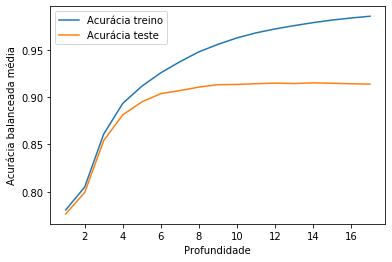

In [6]:
train_perf = []
test_perf = []
depths = list(range(1,18))
for depth in depths:
    clf = tree.DecisionTreeClassifier(max_depth = depth)
    scores = cross_validate(clf, X, y, cv=rskf, scoring = 'balanced_accuracy', return_train_score = True)
    train_perf.append(np.mean(scores['train_score']))
    test_perf.append(np.mean(scores['test_score']))

    
plt.plot(depths, train_perf, label='Acurácia treino')
plt.plot(depths, test_perf, label='Acurácia teste')
plt.xlabel('Profundidade')
plt.ylabel('Acurácia balanceada média')
plt.legend()
plt.show()

**Observação:** Se dermos pouca liberdade em profundidade da árvore, temos um **erro de viés** muito grande. Por outro lado, se dermos muita liberdade de profundidade para a árvore, observamos aumento na **variância**.

Já observamos uma árvore profunda. Vamos olhar agora o extremo oposto disso: uma árvore nada profunda.

In [7]:
clf = tree.DecisionTreeClassifier(max_depth = 1)
model = clf.fit(X, y)
dot_data = tree.export_graphviz(clf, out_file=None, feature_names = X.columns)
graph = graphviz.Source(dot_data) 
graph.render("spambase_prof1")

'spambase_prof1.pdf'

Vamos observar agora uma ávore com uma profundidade mais interessante de acordo com o que observamos entre viés e variância.

In [8]:
clf = tree.DecisionTreeClassifier(max_depth = 5)
model = clf.fit(X, y)
dot_data = tree.export_graphviz(clf, out_file=None, feature_names = X.columns)
graph = graphviz.Source(dot_data) 
graph.render("spambase_prof_interessante")

'spambase_prof_interessante.pdf'

### Mínimo decréscimo de impureza

O hiperparâmetro `min_impurity_decrease` é um valor **ponto flutuante** e seu valor padrão é **0.0**. Um nó só será dividido se a divisão produzir um decréscimo de impureza maior ou igual a este valor.

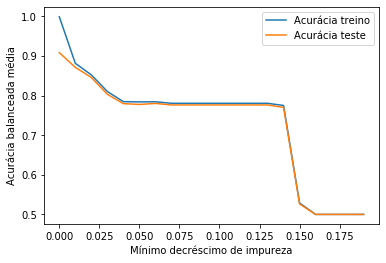

In [9]:
train_perf = []
test_perf = []
values = list(np.arange(0,0.2,0.01))
for value in values:
    clf = tree.DecisionTreeClassifier(min_impurity_decrease = value)
    scores = cross_validate(clf, X, y, cv=rskf, scoring = 'balanced_accuracy', return_train_score = True)
    train_perf.append(np.mean(scores['train_score']))
    test_perf.append(np.mean(scores['test_score']))

    
plt.plot(values, train_perf, label='Acurácia treino')
plt.plot(values, test_perf, label='Acurácia teste')
plt.xlabel('Mínimo decréscimo de impureza')
plt.ylabel('Acurácia balanceada média')
plt.legend()
plt.show()

In [10]:
clf = tree.DecisionTreeClassifier(min_impurity_decrease = 0.01)
model = clf.fit(X, y)
dot_data = tree.export_graphviz(clf, out_file=None, feature_names = X.columns)
graph = graphviz.Source(dot_data) 
graph.render("spambase_minimpuritydecrease", view = True)

'spambase_minimpuritydecrease.pdf'

### Número mínimo de exemplos por nó folha

Outro hiperparâmetro interessante é `min_samples_leaf`. Ele recebe um valor **inteiro** ou **ponto flutuante** e seu valor padrão é **1**. Ele define o número mínimo de instâncias requeridas para um nó folha. Em qualquer nível da árvore, um novo ramo só será formado se o número de exemplos for pelo menos de `min_samples_leaf` em cada um dos nós a serem formados. Ajustar este hiperparâmetro ajuda a deixar a árvore mais suave.

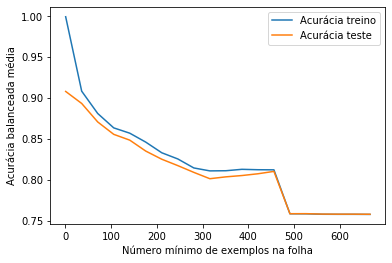

In [11]:
train_perf = []
test_perf = []
values = list(range(1,700,35))
for value in values:
    clf = tree.DecisionTreeClassifier(min_samples_leaf = value)
    scores = cross_validate(clf, X, y, cv=rskf, scoring = 'balanced_accuracy', return_train_score = True)
    train_perf.append(np.mean(scores['train_score']))
    test_perf.append(np.mean(scores['test_score']))

    
plt.plot(values, train_perf, label='Acurácia treino')
plt.plot(values, test_perf, label='Acurácia teste')
plt.xlabel('Número mínimo de exemplos na folha')
plt.ylabel('Acurácia balanceada média')
plt.legend()
plt.show()

In [12]:
clf = tree.DecisionTreeClassifier(min_samples_leaf = 50)
model = clf.fit(X, y)
dot_data = tree.export_graphviz(clf, out_file=None, feature_names = X.columns)
graph = graphviz.Source(dot_data) 
graph.render("spambase_minsamplesleaf", view = True)

'spambase_minsamplesleaf.pdf'

### Peso das classes

O hiperparâmetro `class_weight` pode receber um **dicionário**, uma **lista de dicionários** ou a string **"balanced"**, e seu parâmetro padrão é **None**. Pesos são associados a cada uma das classes na forma ` {rótulo_da_classe: peso}`. Se `None`, todas as classes são consideradas como peso **1**.

Em muitos casos, você tem mais interesse em uma classe do que em outra, ou seja, o custo de errar uma classe é maior do que o de errar outra. No caso de classificar spams, o que é pior: classificar um spam como email ou email como spam? O que nosso modelo está fazendo?

In [13]:
scoring = {'recall0': make_scorer(recall_score, average = None, labels = ['0']), 
           'recall1': make_scorer(recall_score, average = None, labels = ['1']),
           'precision0': make_scorer(precision_score, average = None, labels = ['0']),
           'precision1': make_scorer(precision_score, average = None, labels = ['1'])}
clf = tree.DecisionTreeClassifier(min_samples_leaf = 50)
scores = cross_validate(clf, X, y, cv=rskf, scoring = scoring, return_train_score = True)
result = pd.concat([pd.DataFrame.from_dict(scores).mean(axis = 0), pd.DataFrame.from_dict(scores).std(axis = 0)], axis = 1)
result.columns = ['mean','std']
result

,mean,std
fit_time,0.057797,0.011398
score_time,0.040681,0.008806
test_recall0,0.926541,0.015232
train_recall0,0.934801,0.011901
test_recall1,0.847482,0.023774
train_recall1,0.862825,0.017744
test_precision0,0.903590,0.012893
train_precision0,0.913079,0.009484
test_precision1,0.883068,0.019856
train_precision1,0.896397,0.015268


Nosso modelo está classificando melhor os emails do que os spams. Ainda assim, em torno de 8% de nossos emails ainda estão sendo classificados como spam. Este valor é bom o suficiente? A resposta muitas vezes é subjetiva e depende do especialista de domínio e comparações com outros métodos da área.

Vamos observar o que acontece com essas medidas quando variamos o peso das classes.

In [14]:
train_recall0 = []
train_recall1 = []
train_precision0 = []
train_precision1 = []
test_recall0 = []
test_recall1 = []
test_precision0 = []
test_precision1 = []
values = list(range(1,10,1))
for value in values:
    clf = tree.DecisionTreeClassifier(min_samples_leaf = 50, class_weight = {'0':value, '1':1})
    scores = cross_validate(clf, X, y, cv=rskf, scoring = scoring, return_train_score = True)
    train_recall0.append(np.mean(scores['train_recall0']))
    train_recall1.append(np.mean(scores['train_recall1']))
    train_precision0.append(np.mean(scores['train_precision0']))
    train_precision1.append(np.mean(scores['train_precision0']))
    test_recall0.append(np.mean(scores['test_recall0']))
    test_recall1.append(np.mean(scores['test_recall1']))
    test_precision0.append(np.mean(scores['test_precision0']))
    test_precision1.append(np.mean(scores['test_precision0']))


Text(0.04, 0.5, 'Performance média')

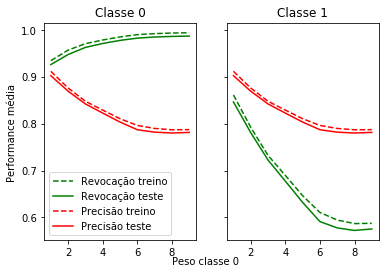

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex = True)

ax1.plot(values, train_recall0, 'g--', label='Revocação treino')
ax1.plot(values, test_recall0, 'g-', label='Revocação teste')
ax1.plot(values, train_precision0, 'r--', label='Precisão treino')
ax1.plot(values, test_precision0, 'r-', label='Precisão teste')
ax1.set_title('Classe 0')

ax1.legend()

ax2.plot(values, train_recall1, 'g--', label='Revocação treino')
ax2.plot(values, test_recall1, 'g-', label='Revocação teste')
ax2.plot(values, train_precision1, 'r--', label='Precisão treino')
ax2.plot(values, test_precision1, 'r-', label='Precisão teste')
ax2.set_title('Classe 1')

fig.text(0.5, 0.04, 'Peso classe 0', ha='center')
fig.text(0.04, 0.5, 'Performance média', va='center', rotation='vertical')

### Usando Gridsearch

Geralmente, usamos alguns metódos que nos auxiliam a escolher o melhor parâmetro. Um deles é o gridsearch que testa todos os valores definidos para cada um dos hiperparâmetros para sugerir uma combinação para sua base de dados. Ele pode ser usado da seguinte forma:

In [10]:
class_weights = []
for i in [1,5,10]:
    class_weights.append({'0': i, '1': 1})

param_grid = {'max_depth': [4,6,8],
              'min_impurity_decrease': [0,0.1,0.2],
              'min_samples_leaf': [25,50,75],
              'class_weight': class_weights}

gscv = GridSearchCV(clf, param_grid, cv = 5, scoring = "balanced_accuracy")

gscv.fit(X, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'class_weight': [{'0': 1, '1': 1}, {'0': 5, '1': 1},


In [8]:
pd.DataFrame.from_dict(gscv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_max_depth,param_min_impurity_decrease,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.027508,0.002437,0.004368,0.000100,"{'0': 1, '1': 1}",4,0,25,"{'class_weight': {'0': 1, '1': 1}, 'max_depth'...",0.848537,0.865029,0.899882,0.886216,0.808932,0.861719,0.031710,5
1,0.024486,0.000211,0.004279,0.000062,"{'0': 1, '1': 1}",4,0,50,"{'class_weight': {'0': 1, '1': 1}, 'max_depth'...",0.849499,0.866406,0.899944,0.880206,0.766481,0.852507,0.046087,6
2,0.024159,0.000179,0.004290,0.000082,"{'0': 1, '1': 1}",4,0,75,"{'class_weight': {'0': 1, '1': 1}, 'max_depth'...",0.826217,0.861500,0.903240,0.884909,0.729742,0.841121,0.061349,9
3,0.017478,0.000286,0.004262,0.000021,"{'0': 1, '1': 1}",4,0.1,25,"{'class_weight': {'0': 1, '1': 1}, 'max_depth'...",0.769921,0.813535,0.760917,0.775154,0.662652,0.756436,0.050216,26
4,0.017534,0.000537,0.004261,0.000035,"{'0': 1, '1': 1}",4,0.1,50,"{'class_weight': {'0': 1, '1': 1}, 'max_depth'...",0.769921,0.813535,0.760917,0.775154,0.662652,0.756436,0.050216,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,0.020406,0.000672,0.006810,0.000125,"{'0': 10, '1': 1}",8,0.1,50,"{'class_weight': {'0': 10, '1': 1}, 'max_depth...",0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,37
77,0.019385,0.000097,0.006513,0.000036,"{'0': 10, '1': 1}",8,0.1,75,"{'class_weight': {'0': 10, '1': 1}, 'max_depth...",0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,37
78,0.019357,0.000148,0.006498,0.000020,"{'0': 10, '1': 1}",8,0.2,25,"{'class_weight': {'0': 10, '1': 1}, 'max_depth...",0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,37
79,0.019263,0.000116,0.006473,0.000037,"{'0': 10, '1': 1}",8,0.2,50,"{'class_weight': {'0': 10, '1': 1}, 'max_depth...",0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,37


In [9]:
gscv.best_params_

{'class_weight': {'0': 1, '1': 1},
 'max_depth': 6,
 'min_impurity_decrease': 0,
 'min_samples_leaf': 25}

In [27]:
clf_tun = tree.DecisionTreeClassifier(**gscv.best_params_)
model = clf_tun.fit(X,y)
dot_data = tree.export_graphviz(clf_tun, out_file=None, feature_names = X.columns)
graph = graphviz.Source(dot_data) 
graph.render("spambase_tree_tun", view = True)

'spambase_tree_tun.pdf'